<a href="https://colab.research.google.com/github/muntrans/Algoritmos_de_Optimizacion/blob/main/Ejercicio_de_clase_Ramificacion_y_Poda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROBLEMA:
Maximizar el rendimiento en la asignación de N tareas a N agentes, cada tarea solo puede ser asignada a un agente.    
Debe aplicarse <u>Ramificación y Poda</u>.
Matriz de beneficios:   
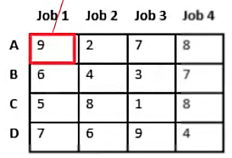


Agentes: A, B, C, D    
Tareas: 1, 2, 3 y 4

Tareas del problema:
- ¿Cómo duseñamos un estado?
- ¿Como expandimos nodos (ramificación)?
- ¿Como recorremos el árbol completo de estados?
- ¿Qué complejidad tiene? --> es dificil de calcular el número de operaciones exacto. Debemos calcular el mejor caso y el peor caso y promediar.
  - Peor caso: tengo que expandir todos los niveles.
  - Mejor caso: puedo podar todos los nodos de un nivel menos uno.
  - En general podemos asumir una complejidad exponencial.

In [58]:
# Matriz
COSTES = [
    [11, 12, 18, 40],
    [14, 15, 13, 22],
    [11, 17, 19, 23],
    [17, 14, 20, 28]
]
# Agentes:
  # 0 = A
  # 1 = B
  # 2 = C
  # 3 = D

# s: agentes
# s: (1, 2) --> agentes B y C

Creamos una función para calcular del coste de una combinacion de agentes respecto ciertas tareas.

In [5]:
# Función Objetivo: esta función te dice exactamente cuánto cuesta esa asignación que tengamos en S.
def valor(S, COSTES):
  # S representa una tupla que es solución
  VALOR = 0
  # Verificar que S tenga la longitud correcta
    #if len(S) != len(COSTES):
        #raise ValueError(f"La asignación {S} no coincide con {len(COSTES)} agentes")
  for i in range(len(S)):
    VALOR += COSTES[i][S[i]]
  return VALOR

print(f"Coste total:{valor((0, 1, 2, 3), COSTES)}") # Ejemplo de asignación
print(f"Coste total:{valor((1, 0, 3, 2), COSTES)}") # Ejemplo de asignación

Coste total:73
Coste total:69


Creamo una función para calcular el coste de todas las posibles combinaciones (usando la funcion _value_ que creamos primero), ademas usaremos permutaciones para requerir menos recursos del ordenador.  

Esta función nos devolvera la combinación de agentes con menor coste.

- Aqui el profesor afronta el problema por FUERZA BRUTA:
  - Generar todas las permutaciones (todas las hojas del árbol)
  - Evaluar cada una secuencialmente
  - Es una búsqueda exhaustiva sin estructura de árbol explícita.

In [6]:
import itertools # usaremos esta biblioteca para crear permutaciones

def fuerza_bruta(COSTES):
# Representación de la solución será una tupla donde cada valor en la cordenada i-sima es la tarea asignado al agente i
  # Ejemplo (1, 2, 3, 4) Tiene valor 11+15+19+28=73
# ¿Cuantas posibilidades hay? n! --> Complejidad factorial (exponencial)
# Con dimensión 11 se va a 1 minuto de ejecución
  mejor_valor = 10e10
  mejor_solucion = ()

  for s in itertools.permutations(range(len(COSTES))): # antes estaba asi: list(itertools.permutations(range(len(COSTES)))): -- quitamos el list(), mejor trabajar con generadores
    # itertools.permutations(...) --> genera todas las formas de ordenar [0, 1, 2, 3] es decir: 24 permutaciones en total (4! = 4×3×2×1 = 24)
    valor_tmp = valor(s, COSTES) # Para cada permutación s, calcula su costo total usando tu función valor.
    if valor_tmp < mejor_valor: # calcula el costo para cada permutacion, si el costo es menor entonces lo asigna a mejor_valor, alfinal mejor_solución tendra el valor de la mejor permutacion "s"
      mejor_valor = valor_tmp
      mejor_solucion = s

  print("La mejor solución es :", mejor_solucion, " con valor:", mejor_valor)

fuerza_bruta(COSTES)

La mejor solución es : (0, 2, 3, 1)  con valor: 61


Creamos una función para estimar una cota inferior para una solución parcial.
- Ahora vamos a tratar el problema como uno de RAMIFICACIÓN Y PODA.   

In [7]:
# Coste inferior para soluciones parciales
  # (1, 3,) Se asigna la tarea 1 al agente 0 y la tarea 3 al agente 1
    # Filas = Agentes (indexados por j)
    # Columnas = Tareas (indexados por i
# La función CI(S, COSTES) devuelve una estimación optimista (cota inferior) del mejor costo total posible que se podría alcanzar completando la asignación parcial S.
def CI(S, COSTES): # Cota Inferior
  VALOR = 0
  # Valores establecidos
  for i in range(len(S)):
    VALOR += COSTES[i][S[i]]

  # Estimación --> lo que FALTA por asignar
  for i in range(len(S), len(COSTES)):
    VALOR += min([COSTES[j][i] for j in range(len(S), len(COSTES))]) # "Para cada tarea sin asignar, toma el agente más barato disponible (entre los no asignados)"
  return VALOR
print(CI((1, 3), COSTES))

76


Aparentemente hay un error en el código del profesor y esta seria una solución más adecuada:

In [8]:
def CI_correcta(S, COSTES):
    VALOR = 0
    # Costo real
    for i in range(len(S)):
        VALOR += COSTES[i][S[i]]

    # Estimación: solo tareas NO asignadas
    tareas_asignadas = set(S)
    agentes_no_asignados = range(len(S), len(COSTES))

    for tarea in range(len(COSTES)):
        if tarea not in tareas_asignadas:
            # Min costo entre agentes no asignados para esta tarea
            min_costo = min(COSTES[agente][tarea] for agente in agentes_no_asignados)
            VALOR += min_costo

    return VALOR
print(CI_correcta((1, 3), COSTES))

64


Efectivamente el profesor esta equivocado. El profesor está usando una heurística simplificada que solo funciona en un caso particular, no en el general. Te explico el núcleo del problema:   
- La función asume que si hay k agentes ya asignados, entonces las k primeras tareas (0, 1, ..., k-1) son las asignadas.   
range(len(S), len(COSTES)) genera índices [2, 3], interpretándolos como "tareas 2 y 3 están libres".
- Pero la tarea 3 NO está libre → ya la tiene el agente 1.   
- Lo que CALCULA: "Costo mínimo para las últimas n-k tareas (índices k..n-1)"
- Lo que DEBERÍA calcular: "Costo mínimo para las tareas REALMENTE no asignadas"   


Ahora vamos con la función para RAMIFICAR.   
- Entender el árbol:
  - Tienes 4 agentes y 4 tareas. Cada "nivel" del árbol decide para un agente específico:
  - Para el ejemplo que haremos si tenemos (0 ,) entonces la siguiente combinación puede ser (0, 1) o (0, 2) o (0, 3).


In [13]:
# Genera tantos hijos como posibilidades haya para el siguiente elemento de la tupla
# (0, ) -> (0, 1), (0, 2), (0, 3)
NODO= (0, )
N = 4
def crear_hijos(NODO, N):
  # NODO: Una asignación parcial, ej: (0, ) o (1, 3)
  # N: Número total de tareas/agentes (ej: 4)
  HIJOS = []
  for i in range(N):
    if i not in NODO:
      HIJOS.append({'s':NODO +(i,)}) # se guarda cada hijo en un diccionario
  return HIJOS
print(crear_hijos(NODO, N))

[{'s': (0, 1)}, {'s': (0, 2)}, {'s': (0, 3)}]


PARTE 1:   
Empezamos con la poda, la idea del siguiente codigo es: "Su MEJOR resultado posible (cota inferior) podría ser MEJOR que la mejor solución que ya tengo".   
- Nodo es interesante SI: CI(nodo) < CotaSup
- Nodo NO es interesante SI: CI(nodo) ≥ CotaSup

In [41]:
def ramificacion_y_poda(COSTES):
# Construcción iterativa de soluciones (arbol). En cada estapa asignamos un agente (ramas).
# Nodos del grafo { s:(1,2), CI:3, CI:5 }
  # pint(COSTES)
  DIMENSION = len(COSTES) # Dimensión del problema, saber cuantos agentes hay
  MEJOR_SOLUCION = tuple(i for i in range(len(COSTES))) # La asignación trivial "cada agente hace la tarea con su mismo número" --> Necesitamos un punto de referencia para comparar, nos valdria cualquier combinación
  CotaSup = valor(MEJOR_SOLUCION, COSTES) # obtenemos el coste de la MEJOR_SOLUCION
  #print("Cota Superior:", CotaSup)

  NODOS = [] # Aqui se guardan los nodos que debemos explorar --> se guarda como lista de diccionarios
  NODOS.append({'s':(), 'ci':CI((), COSTES)}) # Crea el nodo raíz

  iteracion = 0 # Lleva la cuenta de cuántos nodos has expandido


Esta lógica sigue el algoritmo anterior:    
   
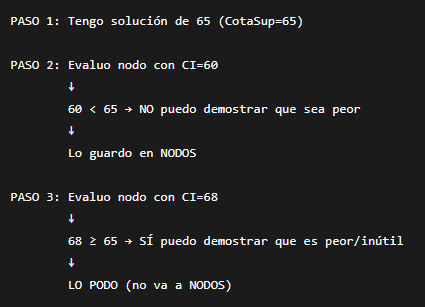

PARTE 2:   
Ahora formando el proceso principal: Ramificación y Poda (Branch and Bound) para resolver el Problema de Asignación.

In [86]:
COSTES = [
    [11, 12, 18, 40],
    [14, 15, 13, 22],
    [11, 17, 19, 23],
    [17, 14, 20, 28]
]

# Aqui meto la función que calcula COSTES
def valor(S, COSTES):
  # S representa una tupla que es solución
  VALOR = 0
  # Verificar que S tenga la longitud correcta
    #if len(S) != len(COSTES):
        #raise ValueError(f"La asignación {S} no coincide con {len(COSTES)} agentes")
  for i in range(len(S)):
    VALOR += COSTES[i][S[i]]
  return VALOR

# Aqui meto la función que calcula CI (corregida por mi)
def CI(S, COSTES):
    VALOR = 0
    # Costo real
    for i in range(len(S)):
        VALOR += COSTES[i][S[i]]

    # Estimación: solo tareas NO asignadas
    tareas_asignadas = set(S)
    agentes_no_asignados = range(len(S), len(COSTES))

    for tarea in range(len(COSTES)):
        if tarea not in tareas_asignadas:
            # Min costo entre agentes no asignados para esta tarea
            min_costo = min(COSTES[agente][tarea] for agente in agentes_no_asignados)
            VALOR += min_costo

    return VALOR

def crear_hijos(NODO, N):
  # NODO: Una asignación parcial, ej: (0, ) o (1, 3)
  # N: Número total de tareas/agentes (ej: 4)
  HIJOS = []
  for i in range(N):
    if i not in NODO:
      HIJOS.append({'s':NODO +(i,)}) # se guarda cada hijo en un diccionario
  return HIJOS
print(crear_hijos(NODO, N))

def ramificacion_y_poda(COSTES):
# Construcción iterativa de soluciones (arbol). En cada estapa asignamos un agente (ramas).
# Nodos del grafo { s:(1,2), CI:3, CI:5 }
  print("Matriz de costes:", COSTES)
  DIMENSION = len(COSTES) # Dimensión del problema, saber cuantos agentes hay
  MEJOR_SOLUCION = tuple(i for i in range(len(COSTES))) # La asignación trivial "cada agente hace la tarea con su mismo número" --> Necesitamos un punto de referencia para comparar, nos valdria cualquier combinación
  print("Mejor solución referencia inicial:", MEJOR_SOLUCION)
  CotaSup = valor(MEJOR_SOLUCION, COSTES) # obtenemos el coste de la MEJOR_SOLUCION
  print("Cota Superior:", CotaSup)

  NODOS = [] # Aqui se guardan los nodos que debemos explorar --> se guarda como lista de diccionarios
  NODOS.append({'s':(), 'ci':CI((), COSTES)}) # Crea el nodo raíz
  print("Nodos:", NODOS) # La primera vez esta vacio, Ci calcula: "Si no he asignado nada todavia cual es el mejor resultado posible a obtener"
  iteracion = 0 # Lleva la cuenta de cuántos nodos has expandido

  while(len(NODOS) > 0):
    iteracion +=1

  # 1: Entre todos los nodos pendientes de explorar elegimos el mas prometedor
    nodo_prometedor = [ min(NODOS, key=lambda x:x["ci"]) ][0]["s"]  # se crea una lista [min()], con [0] accedemos al primer elemento (el diccionario) y con ["s"] accedemos a los values del diccionario con key="s"
      #key=lambda x:x["ci"] -> comparar nodos usando "ci"
      #min(NODOS, key=lambda x:x["ci"]) = El sitio con la mejor estimación
    print("Nodo prometedor:", nodo_prometedor)

  # 2: Ramificacion --> se generan los hijos
    HIJOS = [ {"s":x["s"], "ci":CI(x["s"], COSTES) } for x in crear_hijos(nodo_prometedor, DIMENSION)  ] # asignar los nodos hijos y calcular su "ci" y el coste de esa asignacion
    print("Hijos son:", HIJOS)

  # 3: Revisamos la cota superior y nos quedamos con la mejor solucion si llegamos a una solucion final
    NODO_FINAL = [x for x in HIJOS if len(x["s"]) == DIMENSION] # aqui comprobamos que ya tenemos todas las posibilidades asignadas
    if len(NODO_FINAL) > 0:
      print("Soluciones:", NODO_FINAL)
      if NODO_FINAL[0]["ci"] < CotaSup: # Aqui comprobamos si de la solución encontrada la CotaSuperior es mayor que la del nodo pervio
        CotaSup = NODO_FINAL[0]["ci"] # Entonces substituimos el valor de la CotaSup por el de la nueva asignación
        MejorSolucion = NODO_FINAL # asignamos todo el nodo como la mejor solucion

  # 4: Poda
    HIJOS = [x for x in HIJOS if x["ci"] < CotaSup] # Descartamos hijos cuya estimación (CI) ya supera la mejor solución conocida

  # 5: Añadimos los hijos
    NODOS.extend(HIJOS) # Los hijos que sobrevivieron la poda se añaden a NODOS para explorarlos después

  # 6: Eliminamos el nodo ramificado
    NODOS = [x for x in NODOS if x["s"] != nodo_prometedor] # Quitamos el nodo que acabamos de ramificar porque ya lo procesamos

print(ramificacion_y_poda(COSTES))

[{'s': (0, 1)}, {'s': (0, 2)}, {'s': (0, 3)}]
Matriz de costes: [[11, 12, 18, 40], [14, 15, 13, 22], [11, 17, 19, 23], [17, 14, 20, 28]]
Mejor solución referencia inicial: (0, 1, 2, 3)
Cota Superior: 73
Nodos: [{'s': (), 'ci': 58}]
Nodo prometedor: ()
Hijos son: [{'s': (0,), 'ci': 60}, {'s': (1,), 'ci': 58}, {'s': (2,), 'ci': 65}, {'s': (3,), 'ci': 78}]
Nodo prometedor: (1,)
Hijos son: [{'s': (1, 0), 'ci': 68}, {'s': (1, 2), 'ci': 59}, {'s': (1, 3), 'ci': 64}]
Nodo prometedor: (1, 2)
Hijos son: [{'s': (1, 2, 0), 'ci': 64}, {'s': (1, 2, 3), 'ci': 65}]
Nodo prometedor: (0,)
Hijos son: [{'s': (0, 1), 'ci': 68}, {'s': (0, 2), 'ci': 61}, {'s': (0, 3), 'ci': 66}]
Nodo prometedor: (0, 2)
Hijos son: [{'s': (0, 2, 1), 'ci': 69}, {'s': (0, 2, 3), 'ci': 61}]
Nodo prometedor: (0, 2, 3)
Hijos son: [{'s': (0, 2, 3, 1), 'ci': 61}]
Soluciones: [{'s': (0, 2, 3, 1), 'ci': 61}]
Nodo prometedor: (1, 3)
Hijos son: [{'s': (1, 3, 0), 'ci': 65}, {'s': (1, 3, 2), 'ci': 70}]
Nodo prometedor: (1, 2, 0)
Hijos son